In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
from glob import glob

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import mediapipe as mp

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
epochs = 20
batch_size = 64
lr = 0.001
height = 96
width = 256
num_classes = 9

In [5]:
train_transforms = A.Compose([
                              A.RandomRotate90(p=0.5),
                              A.Flip(p=0.5),
                              A.HorizontalFlip(p=0.5),
                              A.Transpose(p=0.5),
                              A.RandomScale(p=0.2),
                              A.Perspective(p=0.1),
                              A.GaussNoise(p=0.4),
                              A.OneOf([
                                       A.MotionBlur(p=0.2),
                                       A.MedianBlur(blur_limit=3, p=0.1),
                                       A.Blur(blur_limit=3, p=0.1),
                                       ], p=0.2),
                              A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
                              A.OneOf([
                                       A.OpticalDistortion(p=0.1),
                                       A.GridDistortion(p=0.1),
                                       A.Affine(p=0.3),
                                      ], p=0.3),
                              A.OneOf([
                                       A.CLAHE(clip_limit=2),
                                       A.Sharpen(),
                                       A.Emboss(),
                                       A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                                  contrast_limit=0.2, ),
                                       A.HueSaturationValue(hue_shift_limit=0.2, 
                                                            sat_shift_limit=0.2, 
                                                            val_shift_limit=0.2, 
                                                            p=0.4),
                                      ], p=0.65),
                              A.Resize(height=height, width=width, p=1.0),
                              A.Cutout(num_holes=6, max_h_size=10, max_w_size=8, fill_value=0, p=0.1),
                              A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                              ToTensorV2(p=1.0),
                              ], 
                    p=1.0)


valid_transforms = A.Compose([
                      A.Resize(height=height, width=width, p=1.0),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    tensor = tensor 
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    tensor = torch.clamp(tensor * 0.5 + 0.5, min=0., max=1.)
    tensor = tensor.cpu().detach().numpy().transpose(1,2,0)

    return tensor

In [6]:
image_paths = glob("hands/*/*/*.png")
image_paths = [str(path).replace("\\", "/") for path in image_paths]
labels = [path.split("/")[-2].split("_")[-1] for path in image_paths]

In [7]:
data = pd.DataFrame({"path": image_paths, "labels": labels})

labels_to_int = {label: i for i, label in enumerate(data.labels.unique())}
int_to_labels = {i: label for label, i in labels_to_int.items()}

In [8]:
x_train, x_valid = train_test_split(data, test_size=2000, stratify=data["labels"], random_state=42)
x_valid, x_test = train_test_split(x_valid, test_size=200, stratify=x_valid["labels"], random_state=42)

x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print(f"train size: {len(x_train)}, valid size: {len(x_valid)}, test size: {len(x_test)}")

train size: 18000, valid size: 1800, test size: 200


In [9]:
class HandDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix]
        image = Image.open(row["path"]).convert("L")
        image = np.array(image)[..., np.newaxis]
        image = np.repeat(image, repeats=3, axis=-1)

        label = row["labels"]
        
        sample = {"image": image}
        image = self.transforms(**sample)["image"][0,:,:][None]
        
        label = torch.as_tensor(labels_to_int.get(label), dtype=torch.long)
        
        return image, label
    
    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        images, labels = [[tensor[None].to(device) for tensor in subset] for subset in (images, labels)]
        images, labels = [torch.cat(subset) for subset in (images, labels)]
        return images, labels

In [10]:
train_ds = HandDataset(x_train, train_transforms)
valid_ds = HandDataset(x_valid, valid_transforms)
test_ds = HandDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=test_ds.collate_fn)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
        if stride > 1:
            self.downsample = nn.Sequential(
                        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
                        nn.BatchNorm2d(out_channels)
                )
        
    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        
        if self.downsample is not None:
            shortcut = self.downsample(shortcut)
            
        x = x + shortcut
        x = F.relu(x)
        
        return x

In [12]:
class Resnet(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.1):
        super(Resnet, self).__init__()
        self.in_conv = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.in_batch = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_block(64, 64, 1)
        self.layer2 = self.make_block(64, 128, 2)
        self.layer3 = self.make_block(128, 256, 2)
        self.layer4 = self.make_block(256, 512, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def make_block(self, in_channels, out_channels, stride):
        
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels)
            )
    
    def forward(self, x):
        x = self.in_conv(x)
        x = self.in_batch(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.contiguous().view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [13]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    
    images, labels = data
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    
    loss.backward()
    optimizer.step()
    
    accuracy = (torch.max(logits, 1)[1] == labels).float().mean()
    
    return loss.item(), accuracy.item()

def validate_one_batch(data, model, criterion):
    model.eval()
    
    images, labels = batch
    with torch.no_grad():
        logits = model(images)
        
    loss = criterion(logits, labels)
    accuracy = (torch.max(logits, 1)[1] == labels).float().mean()
    
    return loss.item(), accuracy.item()

def test_plot(num_images=12):
    idxs = np.random.choice(np.arange(len(x_test)), size=num_images, replace=False)
    
    images, labels = [], []
    
    for i in idxs:
        row = x_test.iloc[i, :].values
        image = Image.open(row[0]).convert("L").resize((width, height))
        image = np.array(image)[np.newaxis, ...]
        images.append(image)
        labels.append(labels_to_int.get(row[1]))

    img_batch = torch.cat([torch.FloatTensor(image[None] / 127.5 - 1).to(device) for image in images])
    label_batch = torch.as_tensor(labels, dtype=torch.long).view(num_images, -1)
    
    model.eval()
    with torch.no_grad():
        logits = model(img_batch)
    y_pred = torch.max(logits, 1)[1].detach().cpu().numpy().flatten()
    
    num_cols = 4
    num_rows = int(np.ceil(num_images / num_cols))
    plt.figure(figsize=(3*num_rows, num_cols))
    
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(f"GT: {int_to_labels.get(labels[i])}, pred: {int_to_labels.get(y_pred[i])}")
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

In [14]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None, **kwargs):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {'model': Resnet(**kwargs),
                          'state_dict': model.state_dict(),
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [15]:
model = Resnet(in_channels=1, num_classes=9, dropout=0.2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, min_lr=1e-7, patience=3)
stopper = EarlyStopping(patience=5, path="augmodel.pth")

In [16]:
print_freq = 100
params = {"in_channels": 1, "num_classes": num_classes, "dropout": 0.2}

for epoch in range(1, epochs+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', epochs,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
    print()
        
    stopper(np.mean(valid_loss), model, **params)
    if stopper.early_stop:
        checkpoint = torch.load(stopper.path, map_location=device)
        model = checkpoint["model"]
        model.load_state_dict(checkpoint["state_dict"])
        
    scheduler.step(np.mean(valid_loss))
    
test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dl)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)))

epoch: 1 	step: 100 / 282 	train loss: 1.5103 	train accuracy: 0.3125 	time: 7.8149 s
epoch: 1 	step: 200 / 282 	train loss: 1.3512 	train accuracy: 0.5312 	time: 10.9320 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1 / 20 	train loss: 1.3897 	valid loss: 0.8774 	train accuracy 0.4960 	valid accuracy 0.7091

epoch: 2 	step: 100 / 282 	train loss: 1.0640 	train accuracy: 0.6875 	time: 7.8124 s
epoch: 2 	step: 200 / 282 	train loss: 0.5827 	train accuracy: 0.8438 	time: 12.5008 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2 / 20 	train loss: 0.9088 	valid loss: 1.2003 	train accuracy 0.6832 	valid accuracy 0.5598

INFO: Early stopping counter 1 of 5
epoch: 3 	step: 100 / 282 	train loss: 0.5207 	train accuracy: 0.8281 	time: 9.1974 s
epoch: 3 	step: 200 / 282 	train loss: 0.3856 	train accuracy: 0.9219 	time: 9.3736 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3 / 20 	train loss: 0.5914 	valid loss: 0.1767 	train accuracy 0.8059 	valid accuracy 0.9542

Model saved to: augmodel.pth
epoch: 4 	step: 100 / 282 	train loss: 0.5314 	train accuracy: 0.8438 	time: 9.3735 s
epoch: 4 	step: 200 / 282 	train loss: 0.4670 	train accuracy: 0.8281 	time: 7.8067 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4 / 20 	train loss: 0.4274 	valid loss: 0.2102 	train accuracy 0.8602 	valid accuracy 0.9273

INFO: Early stopping counter 1 of 5
epoch: 5 	step: 100 / 282 	train loss: 0.2725 	train accuracy: 0.8750 	time: 9.3749 s
epoch: 5 	step: 200 / 282 	train loss: 0.2545 	train accuracy: 0.8906 	time: 7.8134 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5 / 20 	train loss: 0.3192 	valid loss: 0.2557 	train accuracy 0.8952 	valid accuracy 0.9283

INFO: Early stopping counter 2 of 5
epoch: 6 	step: 100 / 282 	train loss: 0.2628 	train accuracy: 0.9219 	time: 7.8124 s
epoch: 6 	step: 200 / 282 	train loss: 0.2332 	train accuracy: 0.8906 	time: 7.8070 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6 / 20 	train loss: 0.2601 	valid loss: 0.5258 	train accuracy 0.9134 	valid accuracy 0.8168

INFO: Early stopping counter 3 of 5
epoch: 7 	step: 100 / 282 	train loss: 0.1441 	train accuracy: 0.9688 	time: 7.8057 s
epoch: 7 	step: 200 / 282 	train loss: 0.2374 	train accuracy: 0.9375 	time: 9.3755 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7 / 20 	train loss: 0.2348 	valid loss: 0.7427 	train accuracy 0.9218 	valid accuracy 0.7775

INFO: Early stopping counter 4 of 5
epoch: 8 	step: 100 / 282 	train loss: 0.1646 	train accuracy: 0.9375 	time: 7.8058 s
epoch: 8 	step: 200 / 282 	train loss: 0.1698 	train accuracy: 0.9688 	time: 7.8123 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8 / 20 	train loss: 0.1215 	valid loss: 0.0142 	train accuracy 0.9614 	valid accuracy 0.9962

Model saved to: augmodel.pth
epoch: 9 	step: 100 / 282 	train loss: 0.0704 	train accuracy: 0.9844 	time: 7.8059 s
epoch: 9 	step: 200 / 282 	train loss: 0.0915 	train accuracy: 0.9844 	time: 7.8069 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9 / 20 	train loss: 0.0956 	valid loss: 0.0089 	train accuracy 0.9689 	valid accuracy 0.9984

Model saved to: augmodel.pth
epoch: 10 	step: 100 / 282 	train loss: 0.0241 	train accuracy: 1.0000 	time: 8.4253 s
epoch: 10 	step: 200 / 282 	train loss: 0.1452 	train accuracy: 0.9844 	time: 12.4932 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10 / 20 	train loss: 0.0882 	valid loss: 0.0113 	train accuracy 0.9724 	valid accuracy 0.9968

INFO: Early stopping counter 1 of 5
epoch: 11 	step: 100 / 282 	train loss: 0.0745 	train accuracy: 0.9844 	time: 9.3733 s
epoch: 11 	step: 200 / 282 	train loss: 0.0354 	train accuracy: 0.9844 	time: 9.3755 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11 / 20 	train loss: 0.0854 	valid loss: 0.0070 	train accuracy 0.9744 	valid accuracy 0.9978

Model saved to: augmodel.pth
epoch: 12 	step: 100 / 282 	train loss: 0.0442 	train accuracy: 0.9844 	time: 9.3688 s
epoch: 12 	step: 200 / 282 	train loss: 0.1024 	train accuracy: 0.9844 	time: 9.3678 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12 / 20 	train loss: 0.0793 	valid loss: 0.0085 	train accuracy 0.9741 	valid accuracy 0.9968

INFO: Early stopping counter 1 of 5
epoch: 13 	step: 100 / 282 	train loss: 0.0677 	train accuracy: 0.9531 	time: 9.3695 s
epoch: 13 	step: 200 / 282 	train loss: 0.0561 	train accuracy: 1.0000 	time: 7.8041 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13 / 20 	train loss: 0.0766 	valid loss: 0.0058 	train accuracy 0.9754 	valid accuracy 0.9995

Model saved to: augmodel.pth
epoch: 14 	step: 100 / 282 	train loss: 0.0085 	train accuracy: 1.0000 	time: 12.5007 s
epoch: 14 	step: 200 / 282 	train loss: 0.0238 	train accuracy: 0.9844 	time: 10.9380 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14 / 20 	train loss: 0.0745 	valid loss: 0.0082 	train accuracy 0.9766 	valid accuracy 0.9962

INFO: Early stopping counter 1 of 5
epoch: 15 	step: 100 / 282 	train loss: 0.0666 	train accuracy: 0.9844 	time: 9.3750 s
epoch: 15 	step: 200 / 282 	train loss: 0.0792 	train accuracy: 0.9844 	time: 9.3754 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 15 / 20 	train loss: 0.0745 	valid loss: 0.0073 	train accuracy 0.9763 	valid accuracy 0.9968

INFO: Early stopping counter 2 of 5
epoch: 16 	step: 100 / 282 	train loss: 0.0071 	train accuracy: 1.0000 	time: 9.3700 s
epoch: 16 	step: 200 / 282 	train loss: 0.0775 	train accuracy: 0.9688 	time: 8.8399 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 16 / 20 	train loss: 0.0635 	valid loss: 0.0055 	train accuracy 0.9794 	valid accuracy 0.9984

Model saved to: augmodel.pth
epoch: 17 	step: 100 / 282 	train loss: 0.0265 	train accuracy: 1.0000 	time: 15.6190 s
epoch: 17 	step: 200 / 282 	train loss: 0.0070 	train accuracy: 1.0000 	time: 7.7138 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 17 / 20 	train loss: 0.0675 	valid loss: 0.0055 	train accuracy 0.9779 	valid accuracy 0.9978

INFO: Early stopping counter 1 of 5
epoch: 18 	step: 100 / 282 	train loss: 0.0308 	train accuracy: 1.0000 	time: 7.8067 s
epoch: 18 	step: 200 / 282 	train loss: 0.1534 	train accuracy: 0.9688 	time: 10.9315 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 18 / 20 	train loss: 0.0576 	valid loss: 0.0050 	train accuracy 0.9816 	valid accuracy 0.9984

Model saved to: augmodel.pth
epoch: 19 	step: 100 / 282 	train loss: 0.0214 	train accuracy: 1.0000 	time: 7.8133 s
epoch: 19 	step: 200 / 282 	train loss: 0.0412 	train accuracy: 0.9844 	time: 12.5000 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 19 / 20 	train loss: 0.0571 	valid loss: 0.0067 	train accuracy 0.9820 	valid accuracy 0.9984

INFO: Early stopping counter 1 of 5
epoch: 20 	step: 100 / 282 	train loss: 0.0139 	train accuracy: 1.0000 	time: 9.3650 s
epoch: 20 	step: 200 / 282 	train loss: 0.0208 	train accuracy: 1.0000 	time: 9.1520 s


  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 20 / 20 	train loss: 0.0521 	valid loss: 0.0046 	train accuracy 0.9834 	valid accuracy 0.9984

Model saved to: augmodel.pth


  0%|          | 0/4 [00:00<?, ?it/s]

	test loss: 0.0018 	test accuracy 1.0000


In [17]:
checkpoint = torch.load(stopper.path, map_location=device)
model = checkpoint["model"]
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

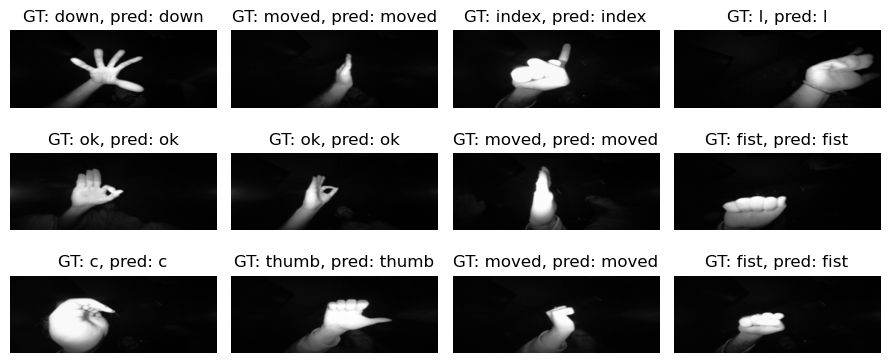

In [18]:
test_plot()

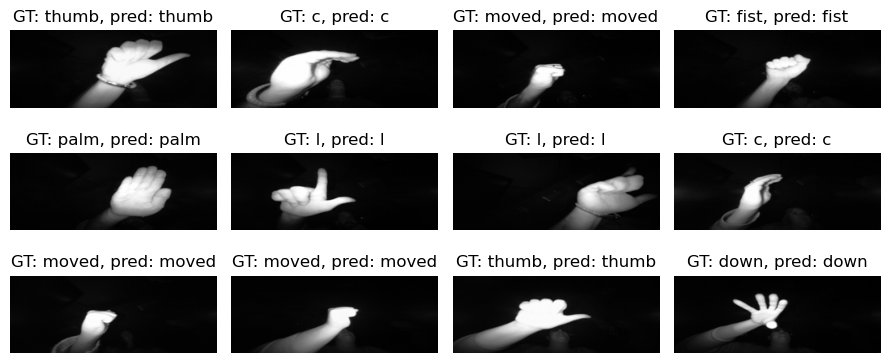

In [19]:
test_plot()

**Experiments with random frames**

In [21]:
mpHands = mp.solutions.hands
hands = mpHands.Hands()

image = cv2.imread("tst.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = hands.process(image)

In [22]:
def get_boxes(image, results):
    h, w, c = image.shape

    hand_landmarks = results.multi_hand_landmarks
    if hand_landmarks:
        hand_boxes = []
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h

            for lm in handLMs.landmark:

                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y

        hand_box = [x_min, y_min, x_max, y_max]
        hand_boxes.append(hand_box)
        return hand_boxes

In [23]:
hand_boxes = get_boxes(image, results)

In [24]:
def crop_hands(image, boxes, threshoded=False):
    hands = []
    h, w, c = image.shape
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        canvas = np.zeros((y_max-y_min, w, 3))
                
        hand_image = image[y_min:y_max, x_min:x_max, :]

        canvas[:, x_min:x_max, :] = hand_image
        canvas = canvas.astype(np.uint8)
        canvas = cv2.cvtColor(canvas, cv2.COLOR_RGB2GRAY)
        if threshoded:
            _, canvas = cv2.threshold(canvas, 100, 255, cv2.THRESH_BINARY)
        hands.append(canvas)
    return hands

In [25]:
images = crop_hands(image, hand_boxes, False)

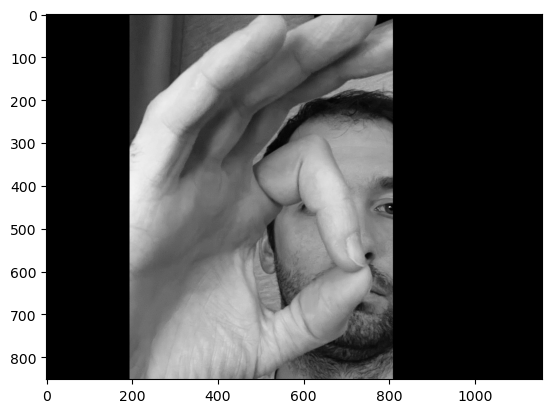

In [26]:
plt.imshow(images[0], cmap="gray")

In [27]:
frame = np.repeat(images[0][..., np.newaxis], repeats=3, axis=-1)
tensor = valid_transforms(image=frame)["image"][0,:,:][None]
tensor = tensor.unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    logits = model(tensor)
    
int_to_labels.get(torch.max(logits, 1)[1].item())

'fist'

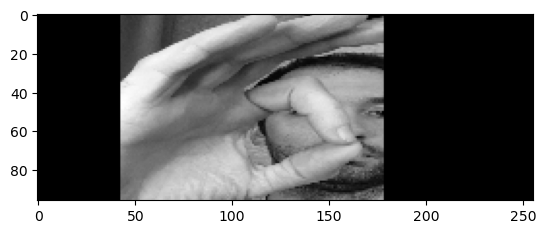

In [28]:
plt.imshow(tensor.cpu().detach().numpy().squeeze(), cmap="gray")

In [29]:
image = cv2.imread("tst.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tensor = valid_transforms(image=image)["image"][0,:,:][None]
tensor = tensor.unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    logits = model(tensor)
    
int_to_labels.get(torch.max(logits, 1)[1].item())

'ok'

In [30]:
def get_convex_crop(image, results):  # rgb image
    hand_landmarks =  results.multi_hand_landmarks
    if not hand_landmarks:
        return image
    
    landmarks = []
    h, w, c = image.shape
    
    for handLMs in hand_landmarks:
        for lm in handLMs.landmark:
            landmarks.append((int(lm.x*w), int(lm.y*h)))
                
    convexHull = cv2.convexHull(np.array(landmarks))
    
    stencil = np.zeros_like(image, dtype=np.uint8)
    cv2.fillPoly(stencil, [convexHull], [255, 255, 255])
    new_image = cv2.bitwise_and(image, stencil)
    
    return new_image

In [33]:
new_image = get_convex_crop(image, results)

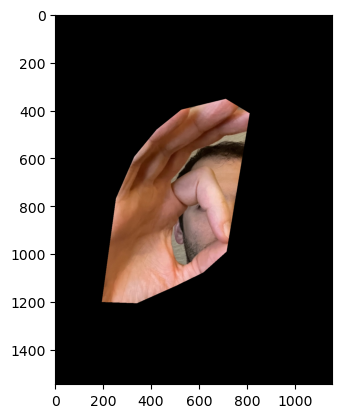

In [34]:
plt.imshow(new_image)

In [35]:
def increase_brightness(img, value=50):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

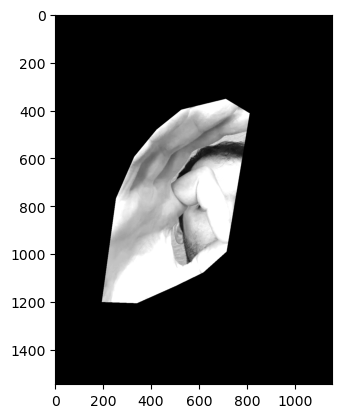

In [36]:
plt.imshow(increase_brightness(new_image)[:,:,0], cmap="gray")